# Выбор локации для скважины

Для добывающей компании «ГлавРосГосНефть» нужно решить задачу, где бурить новую скважину.

Компанией предоставлены пробы нефти в трёх регионах: в каждом 100 000 месторождений, где измерили качество нефти и объём её запасов. Нужно построить модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Необходимо проанализировать возможную прибыль и риски техникой *Bootstrap.*<br>

Порядок шагов для выбора региона:<br>

* В избранном регионе ищут месторождения, для каждого определяют значения признаков;
* Строим модель и оцениваем объём запасов;
* Выбираем месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
* Прибыль равна суммарной прибыли отобранных месторождений.<br>

**Условия задачи:**<br>
* Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).
* При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
* Бюджет на разработку скважин в регионе — 10 млрд рублей.
* При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
* После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.
* Данные синтетические: детали контрактов и характеристики месторождений не разглашаются.

## Загрузка и подготовка данных

In [1]:
# Установка библиотек необходимых для работы кода
!pip install numpy==1.22.4 pandas==1.5.1 -q
!pip install -U scikit-learn -q
!pip install -U scipy -q
#!pip install -U phik -q
#!pip install -U shap -q
#!pip install matplotlib==3.5 -q
# !pip install -U seaborn

In [2]:
# Стандартные библиотеки
import time

# Сторонние библиотеки
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as st

# Модули из библиотеки sklearn
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score, root_mean_squared_error
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [3]:
# Определение констант
RANDOM_STATE = 42

In [4]:
# Загрузка датасета с данными о скважинах по региону 'geo_0'
geo_0 = pd.read_csv('/datasets/geo_data_0.csv', sep=',')

# Загрузка датасета с данными о скважинах по региону 'geo_1'
geo_1 = pd.read_csv('/datasets/geo_data_1.csv', sep=',')

# Загрузка датасета с данными о скважинах по региону 'geo_2'
geo_2 = pd.read_csv('/datasets/geo_data_2.csv', sep=',')

Проверим правильность загрузки и преборазования датасетов.

In [5]:
# Проверка содержания датасетов
print('='*45)

print('\033[1m' + 'Датасет geo_0' + '\033[0m')
display(geo_0.head(2))
print('='*45, '\n')

print('\033[1m' + 'Датасет geo_1' + '\033[0m')
display(geo_1.head(2))
print('='*45, '\n')

print('\033[1m' + 'Датасет geo_2' + '\033[0m')
display(geo_2.head(2))
print('='*45, '\n')

Датасет geo_0


,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.22117,105.280062
1,2acmU,1.334711,-0.340164,4.36508,73.037750



Датасет geo_1


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261



Датасет geo_2


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697


Все датасеты загружены без ошибок. Во всех датасетах одинаковые признаки. Теперь посмотрим общую информацию по каждому датасету.

In [6]:
# Вывод общей информации о датасетах
print('='*45, '\n')

print('\033[1m' + 'Общая информация о датасете geo_0' + '\033[0m' , '\n')
print(geo_0.info())
print('='*45, '\n')

print('\033[1m' + 'Общая информация о датасете geo_1' + '\033[0m' , '\n')
print(geo_1.info())
print('='*45, '\n')

print('\033[1m' + 'Общая информация о датасете geo_2' + '\033[0m' , '\n')
print(geo_2.info())
print('='*45, '\n')


Общая информация о датасете geo_0 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None

Общая информация о датасете geo_1 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None

Общая информация о датасете geo_2 

<class 'pan

**Вывод по разделу 1:**<br>
* В каждом дататсете представлена информация о 100 000 скважинах.
* Все числовые значения имеют соответсвующий тип данных `float64`.
* Пропуски в данных отсутствуют.
* Все датасеты имеют абсолютно одинаковые признаки и тип данных.

## Предобработка данных

Проверим наличие строк-дубликатов во всех датасетах.

In [7]:
# Проверка наличия строк дубликатов в датасетах
print('Количество строк-дубликатов в geo_0:', geo_0.duplicated().sum())
print('Количество строк-дубликатов в geo_1:', geo_1.duplicated().sum())
print('Количество строк-дубликатов в geo_2:', geo_2.duplicated().sum())

Количество строк-дубликатов в geo_0: 0
Количество строк-дубликатов в geo_1: 0
Количество строк-дубликатов в geo_2: 0


Строк дубликатов не выявлено.<br>

Поле с уникальным идентификатором скважины `id` должно быть уникальным в каждом датасете. Проверим теперь наличие дубликатов в поле `id` во всех датасетах.

In [8]:
# Проверка наличия дубликатов в поле 'id'
print('Количество дубликатов в поле `id` в geo_0:', geo_0['id'].duplicated().sum())
print('Количество дубликатов в поле `id` в geo_1:', geo_1['id'].duplicated().sum())
print('Количество дубликатов в поле `id` в geo_2:', geo_2['id'].duplicated().sum())

Количество дубликатов в поле `id` в geo_0: 10
Количество дубликатов в поле `id` в geo_1: 4
Количество дубликатов в поле `id` в geo_2: 4


В каждом датасете встречаются дубликаты значений в поле `id`. Возможно несколько причин появления таких дубликатов:<br>
* ошибочное значение в поле `id`
* строка-дубликат с очень близкими значениями признаков из-за округления при занесении данных (например, 73.604260 и 73.604259)<br>

Выведем и изучим все строки с дубликатами в поле `id` для каждого датасета.

In [9]:
# Вывод всех строк с дубликатами в поле 'id' в датасете 'geo_0'
geo_0[geo_0['id'].duplicated(keep=False)].sort_values('id')

,id,f0,f1,f2,product
66136,74z30,1.084962,-0.312358,6.990771,127.643327
64022,74z30,0.741456,0.459229,5.153109,140.771492
51970,A5aEY,-0.180335,0.935548,-2.094773,33.020205
3389,A5aEY,-0.039949,0.156872,0.209861,89.249364
69163,AGS9W,-0.933795,0.116194,-3.655896,19.230453
42529,AGS9W,1.454747,-0.479651,0.683380,126.370504
931,HZww2,0.755284,0.368511,1.863211,30.681774
7530,HZww2,1.061194,-0.373969,10.430210,158.828695
63593,QcMuo,0.635635,-0.473422,0.862670,64.578675
1949,QcMuo,0.506563,-0.323775,-2.215583,75.496502


In [10]:
# Вывод всех строк с дубликатами в поле 'id' в датасете 'geo_1'
geo_1[geo_1['id'].duplicated(keep=False)].sort_values('id')

,id,f0,f1,f2,product
5849,5ltQ6,-3.435401,-12.296043,1.999796,57.085625
84461,5ltQ6,18.213839,2.191999,3.993869,107.813044
1305,LHZR0,11.170835,-1.945066,3.002872,80.859783
41906,LHZR0,-8.989672,-4.286607,2.009139,57.085625
2721,bfPNe,-9.494442,-5.463692,4.006042,110.992147
82178,bfPNe,-6.202799,-4.820045,2.995107,84.038886
47591,wt4Uk,-9.091098,-8.109279,-0.002314,3.179103
82873,wt4Uk,10.259972,-9.376355,4.994297,134.766305


In [11]:
# Вывод всех строк с дубликатами в поле 'id' в датасете 'geo_2'
geo_2[geo_2['id'].duplicated(keep=False)].sort_values('id')

,id,f0,f1,f2,product
45404,KUPhW,0.231846,-1.698941,4.990775,11.716299
55967,KUPhW,1.211150,3.176408,5.543540,132.831802
11449,VF7Jo,2.122656,-0.858275,5.746001,181.716817
49564,VF7Jo,-0.883115,0.560537,0.723601,136.233420
44378,Vcm5J,-1.229484,-2.439204,1.222909,137.968290
95090,Vcm5J,2.587702,1.986875,2.482245,92.327572
28039,xCHr8,1.633027,0.368135,-2.378367,6.120525
43233,xCHr8,-0.847066,2.101796,5.597130,184.388641


Очевидно, что это не погрешности при округлении, а скорее всего ошибочное значение поля `id`. Поэтому эти строки удалять не будем, так как они тоже несут информацию о скважинах, а поле `id` вряд ли будет обязательным при построении модели.

**Вывод по разделу 2:**<br>
* Строки-дубликаты в датасетах отсутствуют;
* В каждом датасете встречаются несколько дубликатов значений в поле `id`;
* Причиной дубликатов скорее всего являются ошибочные значения поля `id`, так как данные в этих строках разные;
* Все такие дубликаты были оставлены в датасетах.

## Исследовательский анализ данных

Перед исследованием каждого датасета создадим 2 функции, которые будут строить графики.<br>

Сначала напишем функцию, которая будет строить графики распределения (гистограммы) и диаграммы размаха для количественных признаков в датасете, а также считать основные статистики.

In [12]:
def plot_distribution_and_boxplot(df, title='Распределение количественных признаков'):
    """
    Рисует гистограмму и boxplot для числовых признаков,
    а также показывает таблицу статистик.
    """

    # Отбираем столбцы с типом данных float64
    num_columns = df.select_dtypes(include=['float64']).columns.tolist()

    # Строим сетку графиков
    n = len(num_columns)
    fig, axes = plt.subplots(nrows=n, ncols=2, figsize=(15, 4.5*n))
    fig.suptitle(title, fontsize=16, fontweight='bold',y=1.02)

    # Переменная для сбора расчитанных статистик
    stats_rows = []

    for i, col in enumerate(num_columns):
        s = df[col]
        ax1, ax2 = axes[i]

        # Выбор типа графика (bar или hist) и построение
        s.hist(bins=40, ax=ax1, edgecolor='black')
        ax1.set_title(f'Гистограмма: {col}', fontweight='bold')

        ax1.set_xlabel(col); ax1.set_ylabel('Количество')
        ax1.grid(axis='y', alpha=0.3, linestyle='--')
        ax1.grid(axis='x', visible=False)

        # Построение Boxplot
        ax2.boxplot(s, vert=True, labels=[col])
        median_val = s.median()
        mean_val = s.mean()
        ax2.text(0.95, 0.95, f'Медиана: {median_val:.2f}',
                 transform=ax2.transAxes, ha='right', va='top',
                 bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8), fontsize=10)
        ax2.text(0.95, 0.85, f'Среднее: {mean_val:.2f}',
                 transform=ax2.transAxes, ha='right', va='top',
                 bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8), fontsize=10)
        ax2.set_title(f'Диаграмма размаха: {col}', fontweight='bold')
        ax2.set_ylabel(col); ax2.set_xlabel('')
        ax2.grid(axis='y', alpha=0.3, linestyle='--')
        ax2.grid(axis='x', visible=False)

        # Считаем статистики
        q1, q3 = s.quantile([0.25, 0.75])
        iqr = q3 - q1
        stats_rows.append({
            'feature': col,
            'count': int(s.size),
            'mean': round(mean_val, 2),
            'std': round(s.std(ddof=1), 2),
            'min': s.min(),
            'q1 (25%)': q1,
            'median': median_val,
            'q3 (75%)': q3,
            'IQR': iqr,
            'max': s.max(),
            'q1 - 1.5хIQR': max(s.min(), q1 - 1.5*iqr),
            'q3 + 1.5хIQR': min(s.max(), q3 + 1.5*iqr)
        })

    plt.tight_layout()
    plt.show()
   
    # Выводим статистики после графиков
    print('-'*120)
    print('\033[1m' + 'Основные статистики выбранных количественных признаков' + '\033[0m')
    stats_df = pd.DataFrame(stats_rows).set_index('feature')
    display(stats_df)
    print('-'*120)
    

Напишем функцию, которая будет строить точечные `scatterplot` графики зависимости целевого признака от входных признаков.

In [13]:
def geo_scatterplot(df, df_name='', alpha='1'):
    # Сооздаем сетку графиков
    fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(17,5))
    
    # Добавляем общий заголовок
    df_title = 'Зависимость признаков от целевой переменной product в датасете ' + df_name
    fig.suptitle(df_title, fontsize=16) # Заголовок сетки графиков
    fig.subplots_adjust(top=0.85) # Отсут от заголовка
    
    # Строим графики через Seaborn
    sns.scatterplot(x="f0", y="product", data=df, ax=ax1, alpha=alpha)
    sns.scatterplot(x="f1", y="product", data=df, ax=ax2, alpha=alpha)
    sns.scatterplot(x="f2", y="product", data=df, ax=ax3, alpha=alpha)

    # Установка заголовков
    ax1.set_title("Зависимость 'product' от 'f0'") 
    ax2.set_title("Зависимость 'product' от 'f1'") 
    ax3.set_title("Зависимость 'product' от 'f2'") 

    # Выводим график
    plt.show()

___

### Анализ датасета **geo_0**

Посмотрим структуру распределения данных и наличие статистических выбросов.

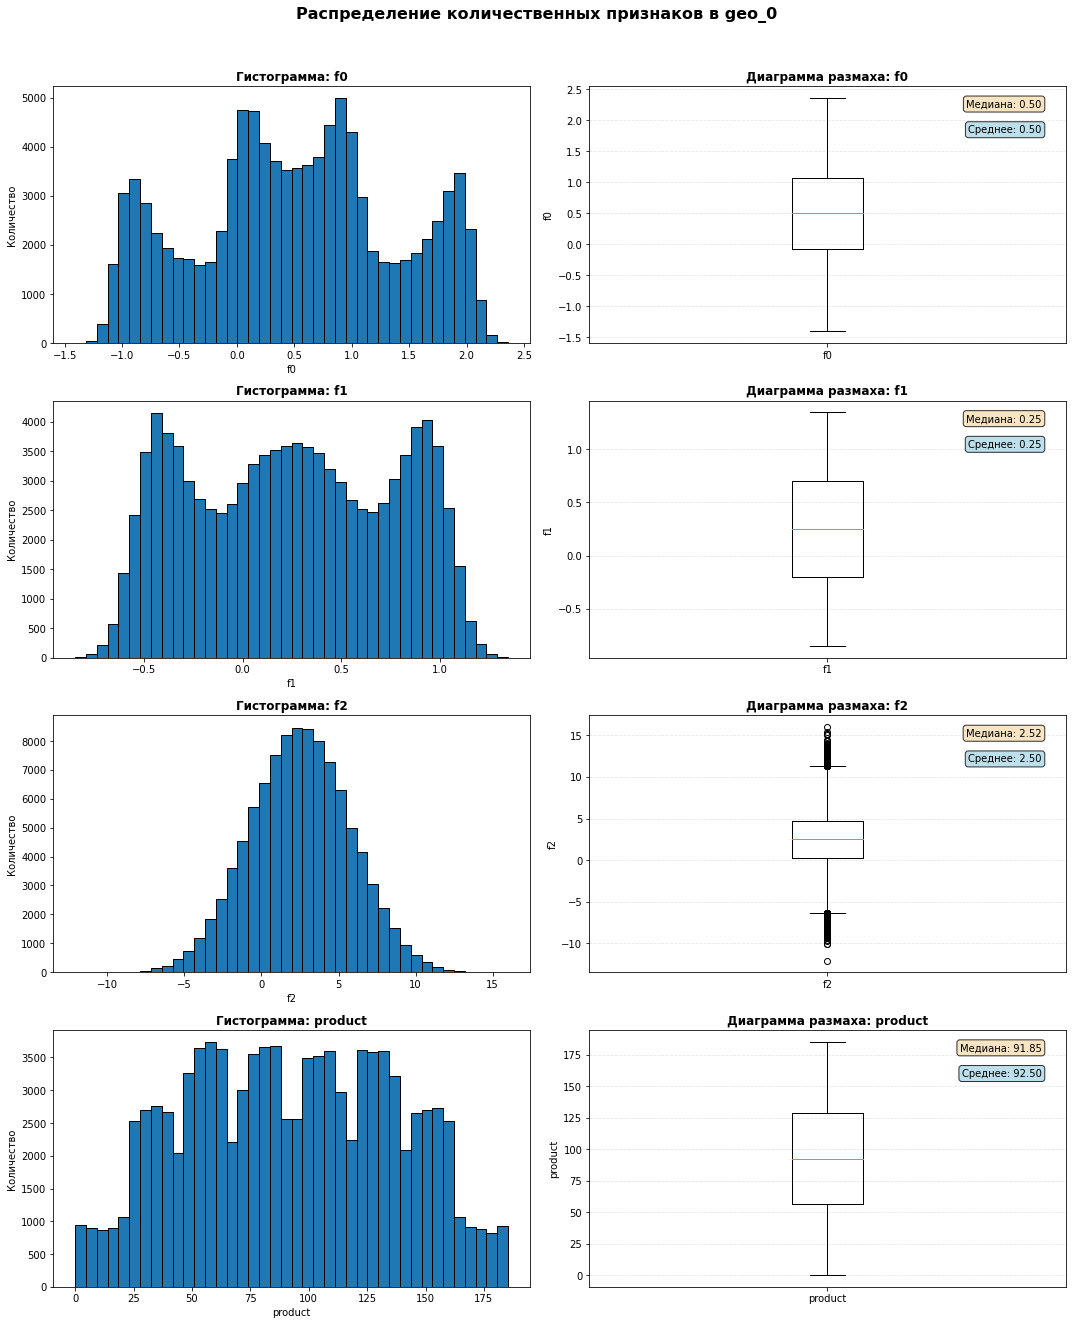

------------------------------------------------------------------------------------------------------------------------
Основные статистики выбранных количественных признаков


,count,mean,std,min,q1 (25%),median,q3 (75%),IQR,max,q1 - 1.5хIQR,q3 + 1.5хIQR
feature,,,,,,,,,,,
f0,100000,0.50,0.87,-1.408605,-0.072580,0.502360,1.073581,1.146162,2.362331,-1.408605,2.362331
f1,100000,0.25,0.50,-0.848218,-0.200881,0.250252,0.700646,0.901528,1.343769,-0.848218,1.343769
f2,100000,2.50,3.25,-12.088328,0.287748,2.515969,4.715088,4.427340,16.003790,-6.353261,11.356098
product,100000,92.50,44.29,0.000000,56.497507,91.849972,128.564089,72.066582,185.364347,0.000000,185.364347


------------------------------------------------------------------------------------------------------------------------


In [14]:
# Строим гистограммы и boxplot для числовых признаков в geo_0
plot_distribution_and_boxplot(geo_0, title='Распределение количественных признаков в geo_0')

По идеальной симметричной форме распределения количественных признаков можно понять, что датасет полностью синтетический (что также указано в условиях задания). Средние и медианные значения очень близки по значению (разница в значениях составляет менее 1%). Признаки `f0` и `f1` имеют мультимодальную форму распределения. Признак `f2` имеет идеальное нормальное распределение, но в обоих хвостах есть статистические выбросы более 1,5 межквартильных размаха. Маловероятно, что эти выбросы являются ошибками измерений. Скорее всего это фактические, но редкие значения, поэтому их удалять нельзя. Мы будем их обрабатывать в пайплайне с помощью винсоризации (усечение до заданного пограничного значения). Если оставить их без обработки, то они могут ухудшить работу модели линейной регрессии.

Построим матрицу корреляции (с коэффициентами Пирсона) между количественными признаками.

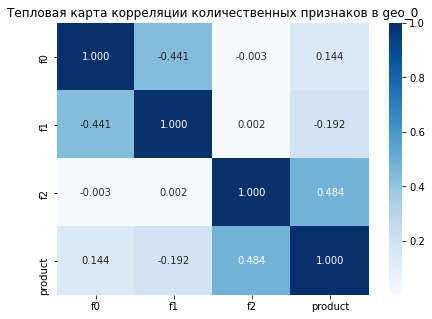

In [15]:
# матрица корреляции количественных признаков
correlation_0 = geo_0.corr(numeric_only=True)
plt.figure(figsize=(7, 5))
sns.heatmap(correlation_0.abs(), annot=correlation_0, cmap='Blues', fmt='.3f')
plt.title('Тепловая карта корреляции количественных признаков в geo_0')
plt.show()

Максимальную корреляцию с целевым признаком `product` имеет признак `f2`, но при этом она все равно достаточно слабая. Остальные признаки имеют очень слабую корреляцию с целевым признаком.<br>

Посмотрим эту связь на точечном графике с помощью ранее созданной функции `geo_scatterplot`. Так как данных очень много в датасете, то для более наглядного представления связи отобразим точки с подобранным уровнем прозрачности.

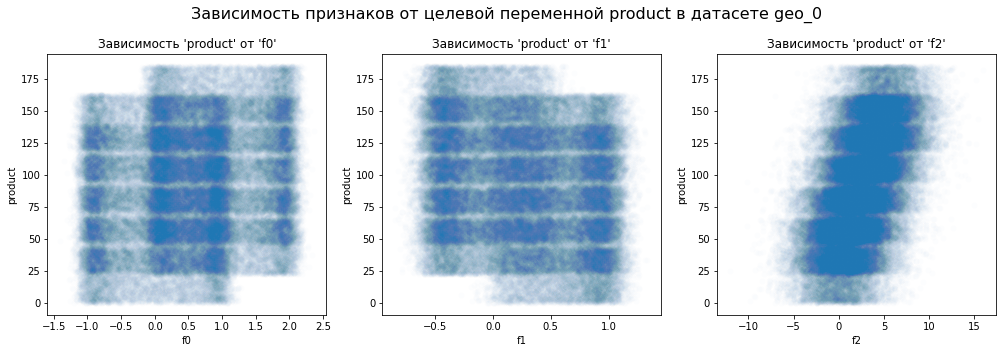

In [16]:
# Строим точечные графики зависимости целевого признака от входных
geo_scatterplot(geo_0, 'geo_0', alpha=0.01)

На этих графиках также видно, что этот датасет полностью искусственный. По таким данным сложно будет построить модель, которая будет давать надежные прогнозы. На третьем графике можно заметить линейную зависимость, но разброс данных вдоль воображаемой линии очень большой. Точность модели будет очень низкой.

### Анализ датасета **geo_1**

Посмотрим структуру распределения данных и наличие статистических выбросов.

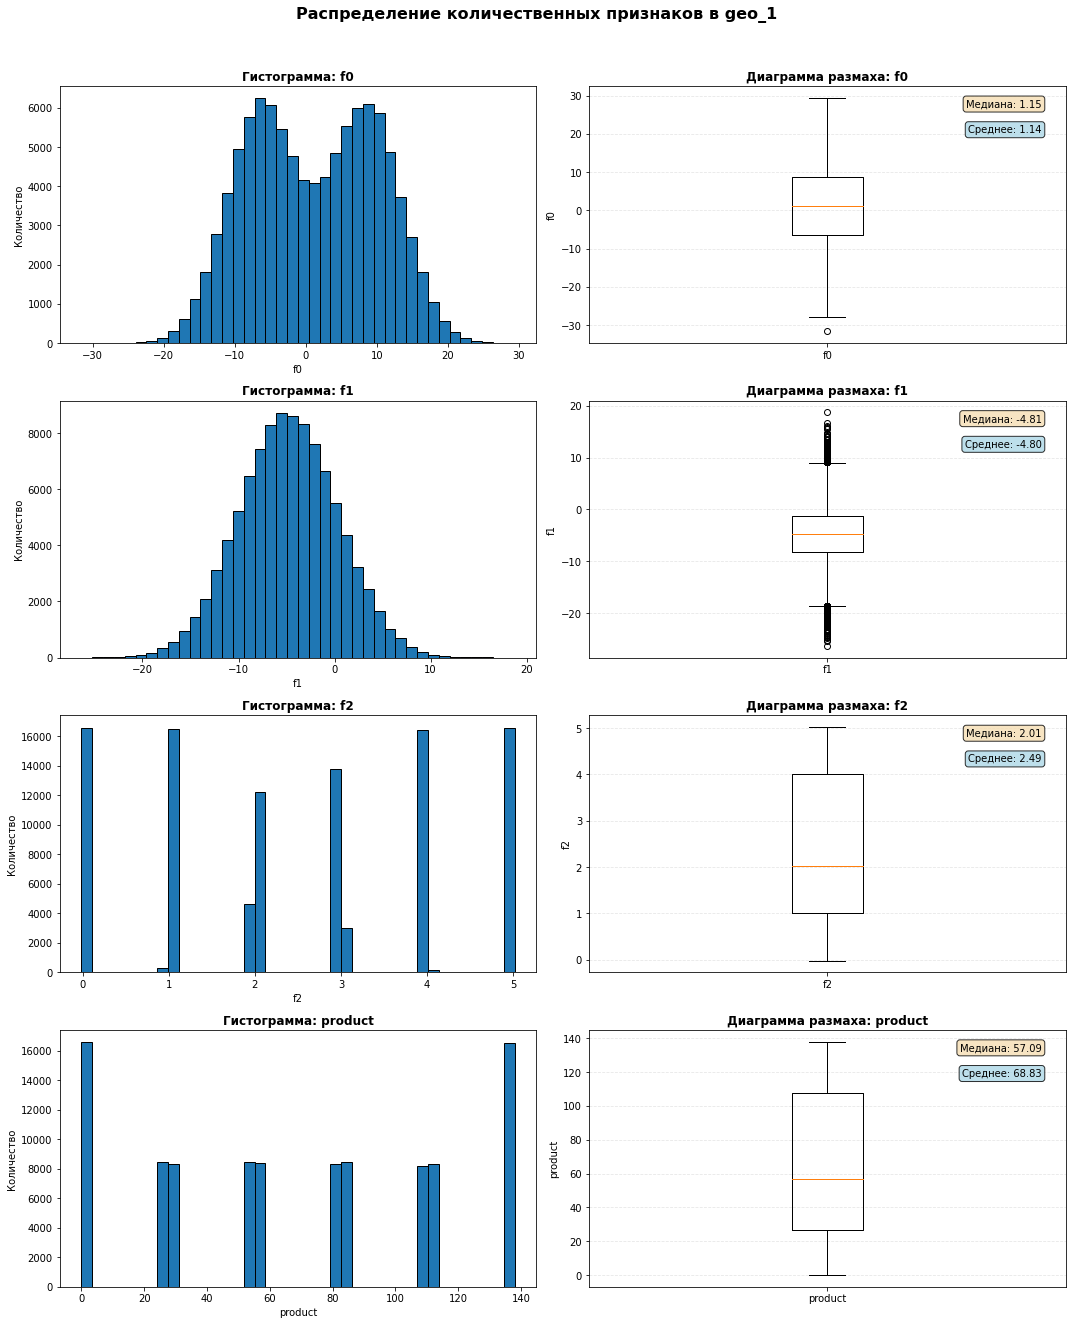

------------------------------------------------------------------------------------------------------------------------
Основные статистики выбранных количественных признаков


,count,mean,std,min,q1 (25%),median,q3 (75%),IQR,max,q1 - 1.5хIQR,q3 + 1.5хIQR
feature,,,,,,,,,,,
f0,100000,1.14,8.97,-31.609576,-6.298551,1.153055,8.621015,14.919567,29.421755,-28.677901,29.421755
f1,100000,-4.80,5.12,-26.358598,-8.267985,-4.813172,-1.332816,6.935169,18.734063,-18.670738,9.069937
f2,100000,2.49,1.70,-0.018144,1.000021,2.011479,3.999904,2.999883,5.019721,-0.018144,5.019721
product,100000,68.83,45.94,0.000000,26.953261,57.085625,107.813044,80.859783,137.945408,0.000000,137.945408


------------------------------------------------------------------------------------------------------------------------


In [17]:
# Строим гистограммы и boxplot для числовых признаков в geo_1
plot_distribution_and_boxplot(geo_1, title='Распределение количественных признаков в geo_1')

По форме распределения количественных признаков можно понять, что этот датасет тоже синтетический. Средние и медианные значения в признаках `f0` и `f1` очень близки по значению (разница в значениях менее 1%). Признак `f0` имеет мультимодальную форму распределения. Признак `f1` имеет нормальное распределение идеальной формы, но в обоих хвостах есть статистические выбросы более 1,5 межквартильных размаха. Маловероятно, что эти выбросы являются ошибками измерений. Скорее всего это фактические, но редкие значения, поэтому их удалять нельзя. Мы будем их обрабатывать в пайплайне с помощью винсоризации (усечение до заданного пограничного значения). Если оставить их без обработки, то они могут ухудшить работу модели линейной регрессии.<br>

Признаки `f2` и `product` по сути представляют собой дискретные значения, хотя данные имеют числовой тип с плавающей запятой. По форме распределения эти признаки очень похожи друг на друга. Очевидно, что этому признаку можно делать точные прогнозы по объему запасов сырья.<br>

Построим матрицу корреляции (с коэффициентами Пирсона) между количественными признаками.

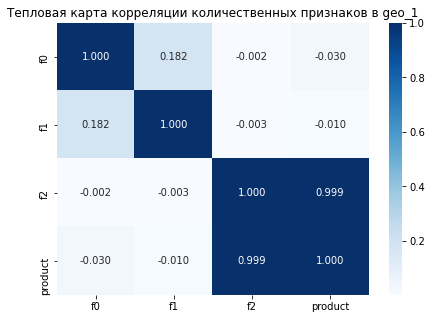

In [18]:
# матрица корреляции количественных признаков
correlation_1 = geo_1.corr(numeric_only=True)
plt.figure(figsize=(7, 5))
sns.heatmap(correlation_1.abs(), annot=correlation_1, cmap='Blues', fmt='.3f')
plt.title('Тепловая карта корреляции количественных признаков в geo_1')
plt.show()

Максимальную корреляцию с целевым признаком `product` имеет признак `f2`, и эта корреляция очень сильная. Это было понятно и по графику распределения (гистограмме). Остальные признаки имеют очень слабую корреляцию с целевым признаком. <br>

В реальных данных признак `f2` нужно было бы исследовать дополнительно на наличие `Data leakage`, но так как датасет искуственный оставим это как есть.

Посмотрим эту связь на точечном графике.

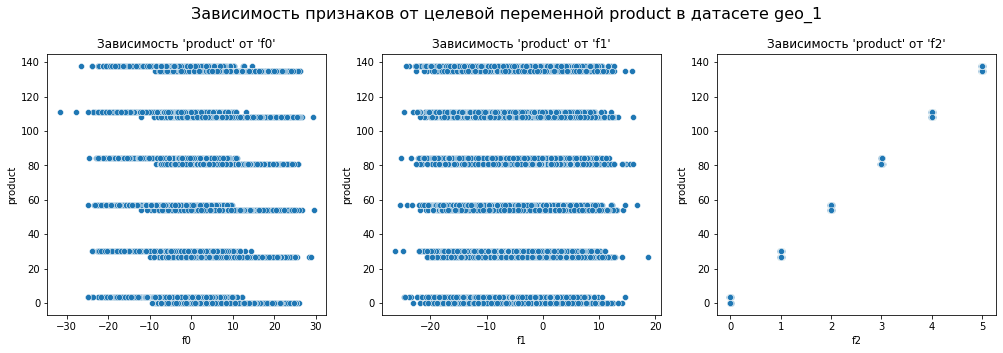

In [19]:
# Строим точечные графики зависимости целевого признака от входных
geo_scatterplot(geo_1, 'geo_1', alpha=1)

На графиках видно, что по значениям признаков `f0` и `f1` невозможно предсказать значение `product`. А на третьем графике видна эта сильная линейная связь, хотя воображаемая линия зависимости на графике прерывистая. Разброс значений вокруг этой линии очень маленький.

### Анализ датасета **geo_2**

Посмотрим структуру распределения данных и наличие статистических выбросов.

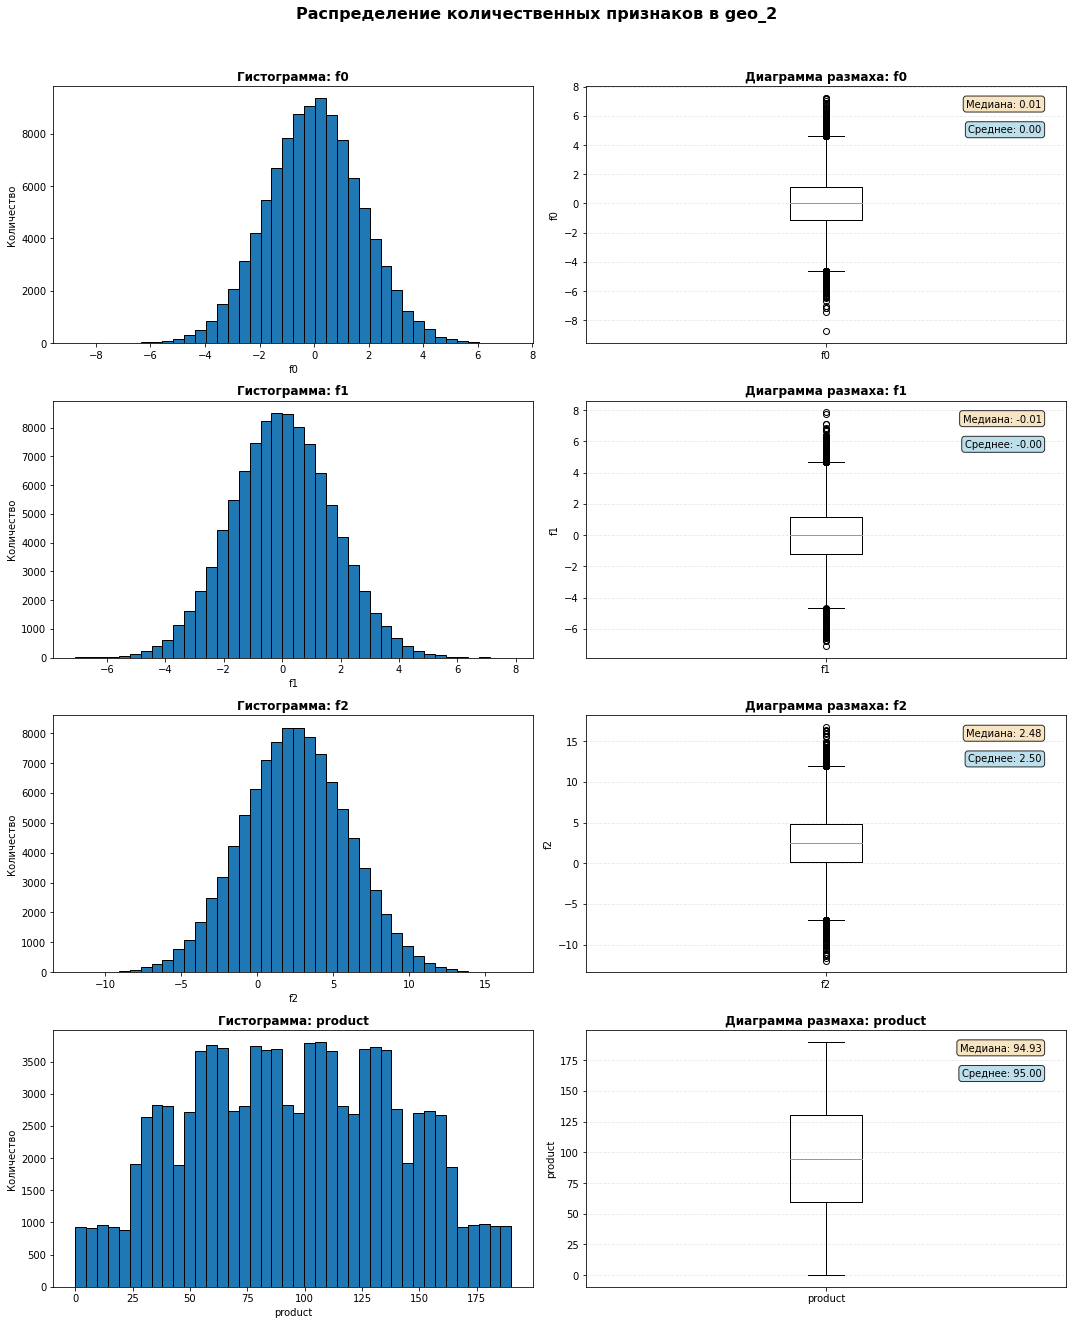

------------------------------------------------------------------------------------------------------------------------
Основные статистики выбранных количественных признаков


,count,mean,std,min,q1 (25%),median,q3 (75%),IQR,max,q1 - 1.5хIQR,q3 + 1.5хIQR
feature,,,,,,,,,,,
f0,100000,0.0,1.73,-8.760004,-1.162288,0.009424,1.158535,2.320824,7.238262,-4.643524,4.639771
f1,100000,-0.0,1.73,-7.084020,-1.174820,-0.009482,1.163678,2.338497,7.844801,-4.682566,4.671424
f2,100000,2.5,3.47,-11.970335,0.130359,2.484236,4.858794,4.728435,16.739402,-6.962294,11.951446
product,100000,95.0,44.75,0.000000,59.450441,94.925613,130.595027,71.144586,190.029838,0.000000,190.029838


------------------------------------------------------------------------------------------------------------------------


In [20]:
# Строим гистограммы и boxplot для числовых признаков в geo_2
plot_distribution_and_boxplot(geo_2, title='Распределение количественных признаков в geo_2')

По идеальной симметричной форме распределения количественных признаков можно понять, что этот датасет также синтетический. Средние и медианные значения очень близки по значению во всех признаках. Признаки `f0`, `f1` и `f2` имеют нормальное распределение идеальной формы. Но в каждом признакеке в обоих хвостах распределения есть статистические выбросы более 1,5 межквартильных размаха. Маловероятно, что эти выбросы являются ошибками измерений. Скорее всего это фактические, но редкие значения, поэтому их удалять нельзя. Мы будем их обрабатывать в пайплайне с помощью винсоризации (усечение до заданного пограничного значения). Если оставить их без обработки, то они могут ухудшить работу модели линейной регрессии.<br>

Целевой признак `product` имеет мультимодальную форму распределения, но статистических выбросов нет.

Построим матрицу корреляции (с коэффициентами Пирсона) между количественными признаками.

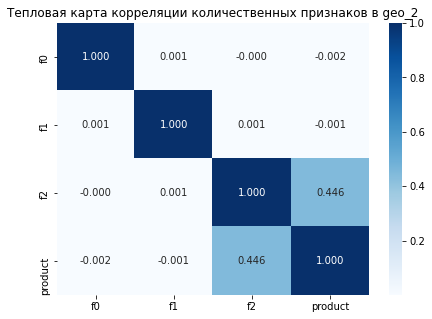

In [21]:
# матрица корреляции количественных признаков
correlation_2 = geo_2.corr(numeric_only=True)
plt.figure(figsize=(7, 5))
sns.heatmap(correlation_2.abs(), annot=correlation_2, cmap='Blues', fmt='.3f')
plt.title('Тепловая карта корреляции количественных признаков в geo_2')
plt.show()

Максимальную корреляцию с целевым признаком `product` имеет признак `f2`, но при этом она все равно достаточно слабая (коэффициент 0.45). Остальные признаки имеют практически нулевую корреляцию с целевым признаком.<br>

Посмотрим связи на точечном графике. Так как данных очень много в датасете, то для более наглядного представления связи отобразим точки с заданным уровнем прозрачности.

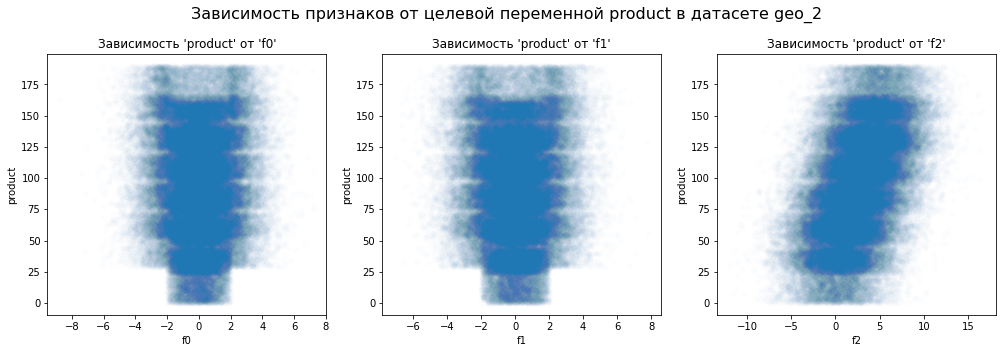

In [22]:
# Строим точечные графики зависимости целевого признака от входных
geo_scatterplot(geo_2, 'geo_2', alpha=0.01)

На этих графиках также видно, что этот датасет полностью искусственный. По таким данным сложно будет построить модель, которая будет давать надежные прогнозы. На третьем графике можно заметить линейную зависимость, но разброс данных вдоль воображаемой линии очень большой. Точность модели будет очень низкой.

**Вывод по разделу 3:**<br>
* Все датасеты синтетические и имеют симметричную форму распределения;
* Средние и медианные значения очень близки по значению во всех датасетах;
* В датасете `geo_0` признаки `f0` и `f1` имеют мультимодальную форму распределения. Признак `f2` имеет нормальное распределение, но в обоих хвостах есть статистические выбросы более 1,5 межквартильных размаха. Максимальную корреляцию с целевым признаком `product` имеет признак `f2`, но при этом она все равно достаточно слабая (0.48). Остальные признаки имеют очень слабую корреляцию с целевым признаком.
* В датасете `geo_1` признак `f0` имеет мультимодальную форму распределения. Признак `f1` имеет нормальное распределение, но в обоих хвостах есть статистические выбросы более 1,5 межквартильных размаха. Признаки `f2` и `product` по сути являются дискретными значениями, хотя данные имеют числовой тип с плавающей запятой. По этому признаку можно делать достаточно точные прогнозы по объему запасов сырья. Максимальную корреляцию с целевым признаком `product` имеет признак `f2`, и эта корреляция очень сильная (0.999). Остальные признаки имеют очень слабую корреляцию с целевым признаком.
* В датасете `geo_2` признаки `f0`, `f1` и `f2` имеют нормальное распределение. Но в каждом признакеке в обоих хвостах распределения есть статистические выбросы более 1,5 межквартильных размаха. Целевой признак `product` имеет мультимодальную форму распределения, но статистических выбросов нет. Максимальную корреляцию с целевым признаком `product` имеет признак `f2`, но при этом она все равно достаточно слабая (коэффициент 0.45). Остальные признаки имеют практически нулевую корреляцию с целевым признаком.
* Во всех датасетах статистические выбросы более 1,5 межквартильных размаха были оставлены без обработки. Они будут обрабатываться при построении модели в пайплайне с помощью винсоризации (усечение до заданного пограничного значения).

## Обучение и проверка модели

Все три датасета имеют разное распределение значений в признаках, поэтому построим для каждого датасета свою линейную модель. В каждом датасете есть входные признаки, которые имеют очень низкую корреляцию с целевым признаком. Но по условию задания все признаки значимы, поэтому удалять их не будем. Для таких данных построим модель линейной регрессии с регуляризацией, которая будет уменьшать значимость (коэффициенты) неважных признаков. Применим для этого модель линейной регрессии `Lasso` (при `alpha = 0` модель `Lasso` превращается в `LinearRegression`). А значение параметра `alpha` будем перебирать в процессе кросс-валидации.

В признаках имеются статистические выбросы, превышающие 1,5 межквартильных размаха. Чтобы сохранить все данные, такие выбросы можно обработать с помощью винсоризации. Но при этом нужно учитывать, что значения межквартильного размаха и пограничные значения выбросов должны рассчитываться именно на тренировочных данных, а потом эти сохраненные значения подставляются при обработке валидационных (тестовых) данных. Если это реализовать с помощью обычной функции, то возникнет утчека данных, так как межквартильный размах и границы будут рассчитываться каждый раз на входящих данных. Поэтому мы создадим кастомный трансформер для пайплайна, в котором будут перебираться гиперпараметры (граница выбросов) в `GridSearchCV`. При этом транфсформер будет запоминать значение межквартильного размаха на тренировочных данных.

In [23]:
# Кастомный трансформер для клиппинга выбросов в датасетах
class Clipper(BaseEstimator, TransformerMixin):
    """Заменяет выбросы граничными значениями на основе значения IQR"""

    def __init__(self, k=1.5):
        self.k = k
        self.lower_bounds_ = None
        self.upper_bounds_ = None

    def fit(self, X, y=None):
        X = np.array(X)
        # Считаем межквартильный размах
        Q1 = np.percentile(X, 25, axis=0)
        Q3 = np.percentile(X, 75, axis=0)
        IQR = Q3 - Q1
        # Рассчитываем граничные значения
        self.lower_bounds_ = Q1 - self.k * IQR
        self.upper_bounds_ = Q3 + self.k * IQR

        return self

    def transform(self, X):
        X = np.array(X)
        # Заменяем выбросы на граничные значения
        X_clipped = np.clip(X, self.lower_bounds_, self.upper_bounds_)
        return X_clipped

Все три датасета одинаковые по количеству строк и структуре признаков, поэтому построим функцию, которая будет перебирать гиперпараметры для лучшей модели, создавать модель линейной регрессии, считать метрики и создавать валидационную выборку с предсказаниями для каждого датасета.

In [24]:
def model_fit(df):
    """
   Разделяет датасет на целевой и входные признаки
   Разделяет признаки на train и valid выборки
   Строит пайплайн с обработкой признаков
   Перебирает гиперпараметры для поиска лучшей модели по метрике RMSE
   Выводит параметры лучшей модели
   Предсказывает значения таргета на валидационном датасете и сохраняет в отдельный датафрейм
    """
    
    # Создаем целевой и входные признаки
    X = df.drop(['id', 'product'], axis=1).copy()
    y = df['product'].copy()
    
    # Создаем тренировочную и валидационную выборки
    X_train, X_valid, y_train, y_valid = train_test_split(X, y,random_state = RANDOM_STATE)
    
    # Определяем числовые входные признаки
    features_num = ['f0', 'f1', 'f2']
    
    # Преообразование числовых признаков (SimpleImputer + clipper + scaler)
    num_pipe = Pipeline([
            ('simpleImputer_num', SimpleImputer(missing_values=np.nan, strategy='mean')),
            ('clipper', Clipper()), # Кастомный трансформер для усечения выбросов
            ('scaler', StandardScaler())
    ])
        
    # Создаём трасформер для колонок
    preprocessor = ColumnTransformer([
            ('num', num_pipe, features_num)
            ], 
        remainder='passthrough'
    )

    # Создаём итоговый пайплайн
    pipe_final= Pipeline([
            ('preprocessor', preprocessor),
            ('model', Lasso())
    ])
    
    # Гиперпараметры для перебора
    param_grid = {
        # перебор вариантов урезания выбросов
        'preprocessor__num__clipper': [Clipper(k=0.5), Clipper(k=1), Clipper(k=1.5), 'passthrough'],
        # перебор вариантов регуляризации
        'model__alpha': [0.01, 0.1, 0.5, 1.0]
    }
    
    grid = GridSearchCV(
    pipe_final, 
    param_grid=param_grid, 
    cv=5, 
    scoring='neg_root_mean_squared_error',
    error_score='raise',
    verbose=1,
    n_jobs=-1
    )
    
    # Фиксируем начальное время перебора параметров
    start_time = time.time()
    
    # Запускаем обучение модели на лучших параметрах
    best_model = grid.fit(X_train, y_train)

    # Фиксируем конечное время и считаем разницу
    end_time = time.time()
    execution_time = end_time - start_time
    print(f"Время обучения модели: {execution_time:.2f} секунд")
    
    # Выводим лучшую модель
    display(best_model.best_estimator_)
    
    # Выводим параметры лучшей модели
    print('\033[1m' + 'Параметры лучшей модели по результатам кросс-валидации:' + '\033[0m')
    display(best_model.best_params_)
    print('\n')
    
    # Выводим RMSE для лучшей модели
    cv_rsme = round(np.abs(grid.best_score_) , 3)
    print('\033[1m' + 'RMSE лучшей модели по результатам кросс-валидации:' + '\033[0m', cv_rsme, 'тыс.барр.')
    print('='*70,'\n')
    
    # Сохраним результаты перебора в датафрейм
    results = pd.DataFrame(best_model.cv_results_)
    
    # Выведем первые три модели с лучшими метриками
    print('\033[1m' + 'Параметры трех лучших моделей по результатам кросс-валидации' + '\033[0m')
    results_sorted = results.query('rank_test_score < 4').sort_values('rank_test_score')\
        [['param_model__alpha', 'param_preprocessor__num__clipper', 'mean_test_score', 'rank_test_score',]]
    results_sorted.rename(columns={
        'param_model__alpha': 'Сила_регуляризации',
        'param_preprocessor__num__clipper': 'Границы_выбросов_IQR*k',
        'mean_test_score': 'Среднее_RMSE',
        'rank_test_score': 'Номер_модели'
    }, inplace=True)
    
    display(results_sorted)
    print('='*70,'\n')
    
    # Предсказываем значения таргета на валидационных данных и сохраняем в датафрейм
    y_pred = best_model.predict(X_valid)
    df_pred = pd.DataFrame({'y_pred': y_pred, 'y_valid': y_valid,}).reset_index(drop=True)
    
    # Считаем и выводим метрики на валидационных данных
    mean_product_true = round(df_pred['y_valid'].mean(), 3)
    mean_product_predict = round(df_pred['y_pred'].mean(), 3)
    
    print('\033[1m' + 'Средний запас фактического сырья:' + '\033[0m', mean_product_true, 'тыс.барр.')
    print('\033[1m' + 'Средний запас предсказанного сырья:' + '\033[0m', mean_product_predict, 'тыс.барр.')

    # Возвращаем датафрейм с истинными и предсказанными значениями таргета
    return df_pred

Построим функцию, которая строит будет считать основные метрики модели (RMSE и R2) и строить графики для ошибок предсказаний модели.

In [25]:
def model_lr_metrics_plot (df, alpha=0.1):
    '''
    Считает метрики качества для обученной модели линейной регрессии
    Строит гистограмму распределения ошибок и график рассеяния ошибок
    Для работы нужны (root_mean_squared_error, r2_score) из библиотеки sklearn.metrics
    y_valid - фактические значения из валидационной выборки, y_pred - предсказания на тестовой выборке
    Функция ничего не возвращает.
    '''
    # Выделяем из df истинные и предсказанные значения
    y_valid = df['y_valid']
    y_pred = df['y_pred']
    
    # Считаем метрики модели
    residuals = y_valid - y_pred
    mean_residuals = round(residuals.mean(), 3)
    rmse = round(root_mean_squared_error(y_valid, y_pred), 3)
    r2 = round(r2_score(y_valid, y_pred), 3)
    
    # Создаем словарь метрик
    metrics = {"rmse": rmse, "r2": r2, 'mean_residuals': mean_residuals}
    
    # Выводим метрики модели
    print('\033[1m' + 'Метрики качества модели линейной регрессии на валидационных данных:' + '\033[0m')
    print("Корень среднекв.  ошибки RMSE:", '\033[1m', rmse,'\033[0m')
    print("Коэффициент детерминации   R2:", '\033[1m', r2,'\033[0m')
    print('='*65)
    print("Смещение среднего значения остатков от нуля (на графике):" + '\033[1m' + '\033[91m', mean_residuals,'\033[0m')

    # Строим графки для ошибок
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14,5))
    axes[0].hist(residuals, bins=20, edgecolor='black', alpha=0.6)
    axes[0].set_title('Гистограмма распределения остатков')
    axes[0].set_xlabel('Остатки')
    axes[0].axvline(x=0, color='#377EB8', linestyle='--', linewidth=2, label='x=0')
    axes[0].axvline(x=np.mean(residuals), color='#E41A1C', linestyle='-', linewidth=2, label='Cреднее остатков')
    axes[0].legend()
    
    # раскраска точек: отрицательные остатки — красные, остальные — синие
    colors = ['red' if r < 0 else 'blue' for r in residuals]
    axes[1].scatter(x=y_pred, y=residuals, c=colors, edgecolor='k', alpha=alpha)
    axes[1].axhline(y=0, color='orange', linestyle='--', linewidth=1)
    axes[1].set_xlabel('Предсказания модели')
    axes[1].set_ylabel('Остатки')
    axes[1].set_title('Анализ дисперсии ошибок')
    axes[1].grid(True, linestyle='--', alpha=0.7)
    
    # легенда для scatter
    import matplotlib.lines as mlines
    red_dot = mlines.Line2D([], [], color='red', marker='o', linestyle='None',
                            markersize=6, label='"−" остатки (завышение прогноза)')
    blue_dot = mlines.Line2D([], [], color='blue', marker='o', linestyle='None',
                             markersize=6, label='"+" остатки (занижение прогноза)')
    axes[1].legend(handles=[red_dot, blue_dot], loc='lower left')
    
    plt.suptitle('Графики распределения ошибок прогноза')    
    plt.tight_layout()
    plt.show()

### Модель для датасета **geo_0**

In [26]:
# Построим модель и получим предсказания для датасета geo_0
pred_geo_0 = model_fit(geo_0)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Время обучения модели: 42.40 секунд


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('simpleImputer_num',
                                                                   SimpleImputer()),
                                                                  ('clipper',
                                                                   Clipper(k=1)),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['f0', 'f1', 'f2'])])),
                ('model', Lasso(alpha=0.01))])

Параметры лучшей модели по результатам кросс-валидации:


{'model__alpha': 0.01, 'preprocessor__num__clipper': Clipper(k=1)}



RMSE лучшей модели по результатам кросс-валидации: 37.629 тыс.барр.

Параметры трех лучших моделей по результатам кросс-валидации


,Сила_регуляризации,Границы_выбросов_IQR*k,Среднее_RMSE,Номер_модели
1,0.01,Clipper(k=1),-37.629210,1
5,0.10,Clipper(k=1),-37.629520,2
9,0.50,Clipper(k=1),-37.637123,3



Средний запас фактического сырья: 92.326 тыс.барр.
Средний запас предсказанного сырья: 92.417 тыс.барр.


Метрики качества модели линейной регрессии на валидационных данных:
Корень среднекв.  ошибки RMSE:  37.708 
Коэффициент детерминации   R2:  0.275 
Смещение среднего значения остатков от нуля (на графике): -0.091 


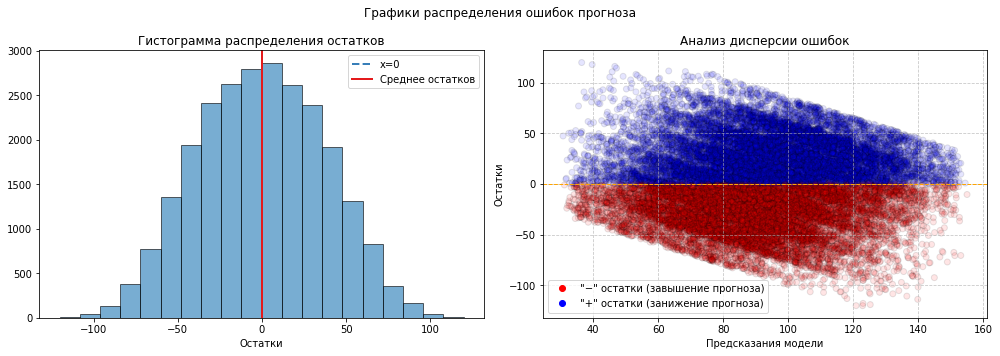

In [27]:
# Строим графики распределения оишбок предсказаний модели
model_lr_metrics_plot(pred_geo_0, alpha=0.1)

**Выводы о работе модели для geo_0:**<br>
* Коэффициент детерминации у модели очень низкий: 0.275;
* Корень среднекв.  ошибки RMSE: 37.708. Это достаточно большое значение при среднем значении: 92.4
* Наименьшее значение RMSE получилось при силе регуляризации: 0.01 (обычная линейная регрессия).
* Наименьшее значение RMSE получилось при усечении выбросов до 1 межквартильного размаха.
* На графике анализа дисперсии ошибок видно, что чем больше предсказанное значение, тем выше вероятность ошибки в сторону завышения. И обратно, чем меньше предсказанное значение, тем выше вероятность ошибки в сторону занижения прогноза.
* В целом, предсказательные способности модели очень низкие.

### Модель для датасета **geo_1**

In [28]:
# Построим модель и получим предсказания для датасета geo_1
pred_geo_1 = model_fit(geo_1)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Время обучения модели: 36.07 секунд


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('simpleImputer_num',
                                                                   SimpleImputer()),
                                                                  ('clipper',
                                                                   Clipper(k=0.5)),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['f0', 'f1', 'f2'])])),
                ('model', Lasso(alpha=0.01))])

Параметры лучшей модели по результатам кросс-валидации:


{'model__alpha': 0.01, 'preprocessor__num__clipper': Clipper(k=0.5)}



RMSE лучшей модели по результатам кросс-валидации: 0.867 тыс.барр.

Параметры трех лучших моделей по результатам кросс-валидации


,Сила_регуляризации,Границы_выбросов_IQR*k,Среднее_RMSE,Номер_модели
0,0.01,Clipper(k=0.5),-0.866930,1
4,0.10,Clipper(k=0.5),-0.882112,2
1,0.01,Clipper(k=1),-0.889919,3



Средний запас фактического сырья: 68.725 тыс.барр.
Средний запас предсказанного сырья: 68.713 тыс.барр.


Метрики качества модели линейной регрессии на валидационных данных:
Корень среднекв.  ошибки RMSE:  0.868 
Коэффициент детерминации   R2:  1.0 
Смещение среднего значения остатков от нуля (на графике): 0.012 


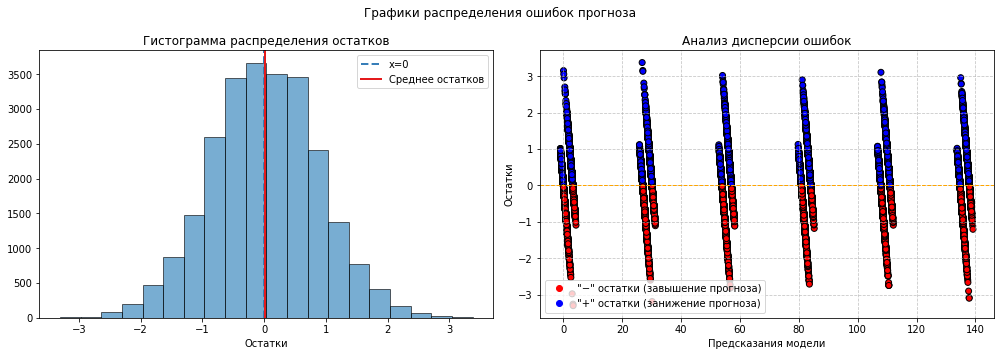

In [29]:
# Строим графики распределения оишбок предсказаний модели
model_lr_metrics_plot(pred_geo_1, alpha=1)

**Выводы о работе модели для geo_1:**<br>
* Коэффициент детерминации у модели максимальный: 1;
* Корень среднекв.  ошибки RMSE: 0.87. Это очень маленькое значение ошибки при среднем значении: 68.7
* Наименьшее значение RMSE получилось при силе регуляризации: 0.01 (обычная линейная регрессия).
* Наименьшее значение RMSE получилось при усечении выбросов до 0.5 межквартильного размаха.
* На графике анализа дисперсии ошибок видно, что ошибки совсем незначительные.
* Предсказательные способности модели очень высокие, модель будет давать очень точные прогнозы.

### Модель для датасета **geo_2**

In [30]:
# Построим модель и получим предсказания для датасета geo_2
pred_geo_2 = model_fit(geo_2)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Время обучения модели: 39.50 секунд


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('simpleImputer_num',
                                                                   SimpleImputer()),
                                                                  ('clipper',
                                                                   Clipper(k=1)),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['f0', 'f1', 'f2'])])),
                ('model', Lasso(alpha=0.1))])

Параметры лучшей модели по результатам кросс-валидации:


{'model__alpha': 0.1, 'preprocessor__num__clipper': Clipper(k=1)}



RMSE лучшей модели по результатам кросс-валидации: 39.992 тыс.барр.

Параметры трех лучших моделей по результатам кросс-валидации


,Сила_регуляризации,Границы_выбросов_IQR*k,Среднее_RMSE,Номер_модели
5,0.10,Clipper(k=1),-39.991505,1
1,0.01,Clipper(k=1),-39.991913,2
9,0.50,Clipper(k=1),-39.994298,3



Средний запас фактического сырья: 95.151 тыс.барр.
Средний запас предсказанного сырья: 94.754 тыс.барр.


Метрики качества модели линейной регрессии на валидационных данных:
Корень среднекв.  ошибки RMSE:  40.122 
Коэффициент детерминации   R2:  0.197 
Смещение среднего значения остатков от нуля (на графике): 0.397 


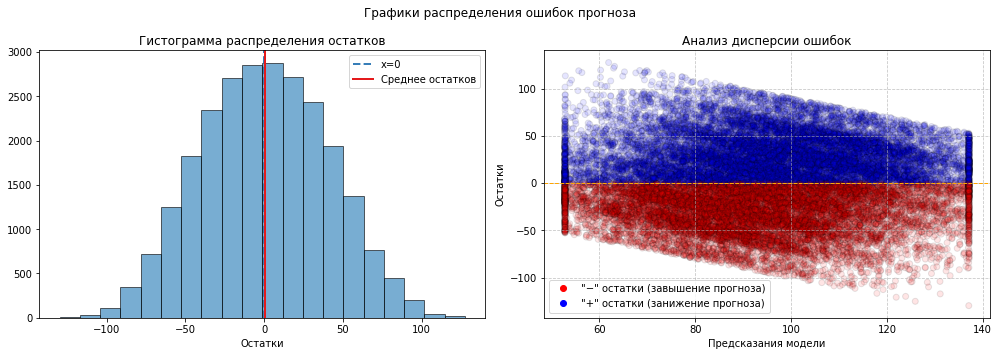

In [31]:
# Строим графики распределения оишбок предсказаний модели
model_lr_metrics_plot(pred_geo_2, alpha=0.1)

**Выводы о работе модели для geo_2:**<br>
* Коэффициент детерминации у модели самый низкий из всех моделей: 0.197;
* Корень среднекв.  ошибки RMSE: 40.1. Это достаточно большое значение ошибки при среднем значении: 94.7
* Наименьшее значение RMSE получилось при силе регуляризации: 0.1.
* Наименьшее значение RMSE получилось при усечении выбросов до 1 межквартильного размаха.
* На графике анализа дисперсии ошибок видно, что чем больше предсказанное значение, тем выше вероятность ошибки в сторону завышения. И обратно, чем меньше предсказанное значение, тем выше вероятность ошибки в сторону занижения прогноза.
* В целом, предсказательные способности модели очень низкие.

**Вывод по всему разделу 4:**<br>
* Самое высокое фактичекое среднее значение запасов сырья в регионе "2" (95.2 тыс.барр.), но у модели для этого региона самые низкие предсказательные способности и максимальная ошибка RMSE = 40.1 тыс. барр.;
* Чуть среднее фактичекое значение запасов сырья в региона "0" (92.3 тыс.барр.). У модели для этого региона тоже низкие предсказательные способности и максимальная ошибка RMSE = 37.8 тыс. барр.;
* Самое низкое фактичекое среднее значение запасов сырья в регионе "1" (68.7 тыс.барр.), но зато у модели для этого региона самые высокие предсказательные способности и минимальная ошибка RMSE = 0.87 тыс. барр.;

## Подготовка к расчёту прибыли

Сохраним ключевые значения для расчета прибыли разработки скважин в отдельные переменные.<br>

Для расчета прибыльности разработки и безубыточности одной скважины нам потребуются следующие данные:<br>
* Бюджет на разработку скважин в регионе: 10 млрд. ₽.
* Доход с обного барреля сырья: 450₽ (доход с 1 тыс. барр. - 450 000 ₽).
* Количество скважин для исследования перед разработкой: 500 скважин.
* Количество скважин для разработки: 200 скважин.

In [32]:
# Бюджет на разработку 200 скважин
BUDGET = 10_000_000_000

# Доход с 1 тыс. барр. сырья 
REVENUE_1000_BBL  = 450_000

# Количество скважин для исследования 
BOREHOLES_RESEARCH = 500

# Количество скважин для разработки 
BOREHOLES = 200

На основе этих данных рассчитаем каким должен быть минимальный средний запас сырья в одной скважине для безубыточной разработки одной скважины:<br>
* Сначала посчитаем стоимость разработки одной скважины: бюджет на разработку скважин в регионе разделить на 200 скважин.<br>
* Затем среднюю стоимость разработки одной скважины разделим на доход с 1 тыс. барр. сырья (450 000 ₽).<br>

А после расчета, сравним минимальный средний запас сырья в одной скважине со средним запасом одной скважины для каждого региона.

In [33]:
#Считаем средний минимальный запас сырья в одной скважине
min_product = round((BUDGET / BOREHOLES) / REVENUE_1000_BBL, 2)
print('-'*95)
print('\033[1m' + 'Средний минимальный запас сырья в одной скважине для безубыточной разработки:',
      min_product, 'тыс. барр.', '\033[0m')

#Считаем средний запас сырья и стандартное отклонение для каждого региона
product_mean_true_0 = round(pred_geo_0['y_valid'].mean(), 2)
product_std_true_0 = round(pred_geo_0['y_valid'].std(), 2)

product_mean_true_1 = round(pred_geo_1['y_valid'].mean(), 2)
product_std_true_1 = round(pred_geo_1['y_valid'].std(), 2)

product_mean_true_2 = round(pred_geo_2['y_valid'].mean(), 2)
product_std_true_2 = round(pred_geo_2['y_valid'].std(), 2)

print('-'*95)
print("Средний минимальный запас сырья в одной скважине в регионе 0:", '\033[1m', product_mean_true_0, 'тыс. барр.', '\033[0m')
print("Стандартное отклонение запасов сырья в регионе 0:", '\033[1m', product_std_true_0, 'тыс. барр.', '\033[0m')
print('\n')
print("Средний минимальный запас сырья в одной скважине в регионе 1:", '\033[1m', product_mean_true_1, 'тыс. барр.', '\033[0m')
print("Стандартное отклонение запасов сырья в регионе 1:", '\033[1m', product_std_true_1, 'тыс. барр.', '\033[0m')
print('\n')
print("Средний минимальный запас сырья в одной скважине в регионе 2:", '\033[1m', product_mean_true_2, 'тыс. барр.', '\033[0m')
print("Стандартное отклонение запасов сырья в регионе 2:", '\033[1m', product_std_true_2, 'тыс. барр.', '\033[0m')
print('-'*95)

-----------------------------------------------------------------------------------------------
Средний минимальный запас сырья в одной скважине для безубыточной разработки: 111.11 тыс. барр. 
-----------------------------------------------------------------------------------------------
Средний минимальный запас сырья в одной скважине в регионе 0:  92.33 тыс. барр. 
Стандартное отклонение запасов сырья в регионе 0:  44.28 тыс. барр. 


Средний минимальный запас сырья в одной скважине в регионе 1:  68.73 тыс. барр. 
Стандартное отклонение запасов сырья в регионе 1:  45.95 тыс. барр. 


Средний минимальный запас сырья в одной скважине в регионе 2:  95.15 тыс. барр. 
Стандартное отклонение запасов сырья в регионе 2:  44.78 тыс. барр. 
-----------------------------------------------------------------------------------------------


Фактический средний запас сырья на одну скважину в каждом регионе значительно меньше минимального среднего запаса для безубыточной разработки, особенно в регионе '1'. При этом также в каждом регионе достаточно высокие значение стандартного отклонения от среднего значения. Поэтому модель должна наиболее точно пресказывать высокие значения запасов сырья. Однако, на графике анализа ошибок для моделей регионов '0' и '2' происходит обратное: чем выше предсказанное значение, тем выше ошибка в сторону завышения прогноза, и тем меньше значения ошибок в сторону занижения прогнозов. Таким образом, если мы будем отбирать максимальные предсказанные значения, тем выше риск того, что фактические запасы будут значительно ниже.<br>

Если мы в валидационной выборке отберем предсказанные значения запасов сырья более минималього среднего значения, то увидим, что большое количество фактических значений запасов сырья будет менее минимального среднего значения. Таким образом,  есть достаточно высокая вероятность того, что  из-за ошибок предсказаний модели в разработку будут попадать скважины с запасами сырья менее минимального среднего значения, что негативно повлияет на общую прибыль от разработки скважин в регионе.

Посмотрим на графике для регионов '0' и '2' сколько среди позитивно предсказанных значений запасов (более минимального среднего значения) с фактическим запасом менее среднего минимального.

**Анализ предсказаний запасов сырья для расчета прибыли в регионе '0'**

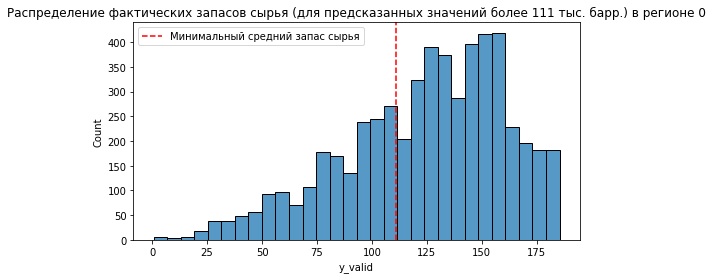

In [34]:
# Строим график распределения фактических значений запасов сырья для регоина 0
plt.figure(figsize=(8,4))

# Отрираем все предсказанные значения более минимального среднего запаса
sns.histplot(data=pred_geo_0.query('y_pred > @min_product'), x='y_valid', bins=30)

plt.axvline(x=min_product, color='red', linestyle='--', label=f'Минимальный средний запас сырья')
plt.title("Распределение фактических запасов сырья (для предсказанных значений более 111 тыс. барр.) в регионе 0")
plt.legend()
plt.show()

Посчитаем теперь количество предсказанных запасов сырья более минимального среднего значения, и сколько из них фактически больше минимального среднего значения. И посчитаем среднее значение для этих фактических запасов.

In [35]:
# Считаем значения
n_pred_0 = len(pred_geo_0.query('y_pred > @min_product'))
n_valid_0 = len(pred_geo_0.query('y_pred > @min_product & y_valid > @min_product'))
n_rate_0 = round((n_valid_0 / n_pred_0)*100, 2)
mean_valid_0 = round(pred_geo_0.query('y_pred > @min_product & y_valid > @min_product')['y_valid'].mean(), 2)

print('\033[1m' + 'Распределение фактических и предсказанных значений запасов сырья в регионе "0"' + '\033[0m')
print('-'*60)
print(f"Количество предсказанных значений более 'min_product': {n_pred_0}")
print(f"Из них кол-во фактических значений более 'min_product': {n_valid_0}")
print(f"Доля фактических значений более 'min_product': {n_rate_0}%")
print(f"Среднее значение этих фактических запасов: {mean_valid_0} тыс. барр.")
print('-'*60)

Распределение фактических и предсказанных значений запасов сырья в регионе "0"
------------------------------------------------------------
Количество предсказанных значений более 'min_product': 5423
Из них кол-во фактических значений более 'min_product': 3621
Доля фактических значений более 'min_product': 66.77%
Среднее значение этих фактических запасов: 145.48 тыс. барр.
------------------------------------------------------------


Для всех предсказанных значений более минимального среднего значения, около 1/3 скважин будут иметь фактический запас сырья меньше минимального среднего значения. Это сильно повышает риск убыточности разработки в регионе "0" из-за ошибок предсказаний модели.

**Анализ предсказаний запасов сырья для расчета прибыли в регионе '1'**

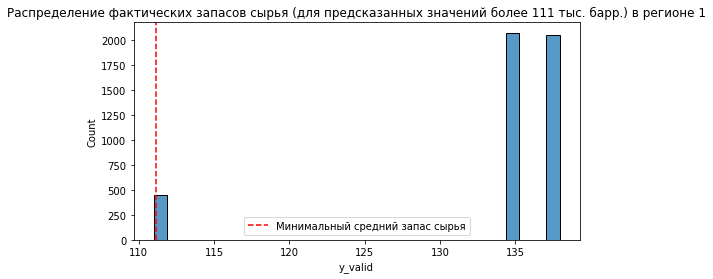

In [36]:
# Строим график распределения фактических значений запасов сырья для регоина 1
plt.figure(figsize=(8,4))

# Отрираем все предсказанные значения более минимального среднего запаса
sns.histplot(data=pred_geo_1.query('y_pred > @min_product'), x='y_valid', bins=30)

plt.axvline(x=min_product, color='red', linestyle='--', label=f'Минимальный средний запас сырья')
plt.title("Распределение фактических запасов сырья (для предсказанных значений более 111 тыс. барр.) в регионе 1")
plt.legend()
plt.show()

В датасете по региону '1' для всех предсказанных значений более минимального среднего значения, все скважины будут также иметь фактический запас сырья больше минимального среднего значения. Ошибка предсказаний близка к нулю. Модель позволит достоверно отобрать максимальные значения запасов сырья. Но при этом, что среднее значение запасов по этому региону самое низкое, что повышает риск возникновения убытков из-за случаности распределения при отборе скважин.

**Анализ предсказаний запасов сырья для расчета прибыли в регионе '2'**

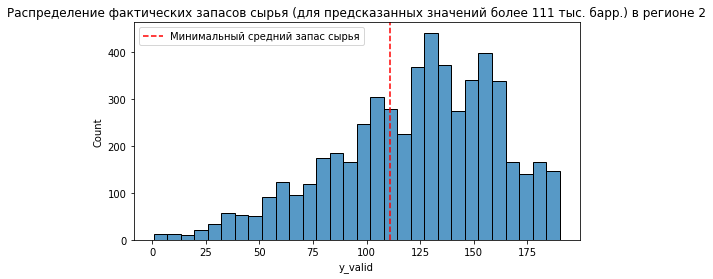

In [37]:
# Строим график распределения фактических значений запасов сырья для регоина 2
plt.figure(figsize=(8,4))

# Отрираем все предсказанные значения более минимального среднего запаса
sns.histplot(data=pred_geo_2.query('y_pred > @min_product'), x='y_valid', bins=30)

plt.axvline(x=min_product, color='red', linestyle='--', label=f'Минимальный средний запас сырья')
plt.title("Распределение фактических запасов сырья (для предсказанных значений более 111 тыс. барр.) в регионе 2")
plt.legend()
plt.show()

Посчитаем теперь количество предсказанных запасов сырья более минимального среднего значения, и сколько из них фактически больше минимального среднего значения. И посчитаем среднее значение для этих фактических запасов.

In [38]:
# Считаем значения
n_pred_2 = len(pred_geo_2.query('y_pred > @min_product'))
n_valid_2 = len(pred_geo_2.query('y_pred > @min_product & y_valid > @min_product'))
n_rate_2 = round((n_valid_2 / n_pred_2)*100, 2)
mean_valid_2 = round(pred_geo_2.query('y_pred > @min_product & y_valid > @min_product')['y_valid'].mean(), 2)

print('\033[1m' + 'Распределение фактических и предсказанных значений запасов сырья в регионе "2"' + '\033[0m')
print('-'*60)
print(f"Количество предсказанных значений более 'min_product': {n_pred_2}")
print(f"Из них кол-во фактических значений более 'min_product': {n_valid_2}")
print(f"Доля фактических значений более 'min_product': {n_rate_2}%")
print(f"Среднее значение этих фактических запасов: {mean_valid_2} тыс. барр.")
print('-'*60)

Распределение фактических и предсказанных значений запасов сырья в регионе "2"
------------------------------------------------------------
Количество предсказанных значений более 'min_product': 5412
Из них кол-во фактических значений более 'min_product': 3510
Доля фактических значений более 'min_product': 64.86%
Среднее значение этих фактических запасов: 145.64 тыс. барр.
------------------------------------------------------------


Для всех предсказанных значений более минимального среднего значения, около 1/3 скважин будут иметь фактический запас сырья меньше минимального среднего значения. Это сильно повышает риск убыточности разработки в регионе "0" из-за ошибок предсказаний модели.

**Вывод по разделу 5:**<br>
* На основе исходных данных был рассчитан рассчитан минимальный средний запас сырья в одной скважине для безубыточной разработки одной скважины. Для этого бюджет на разработку скважин в регионе (10_000_000_000 ₽) разделили на 200 скважин. А затем среднюю стоимость разработки одной скважины разделили на доход с 1 тыс. барр. сырья (450 000 ₽). Таким образом, минимальный средний запас сырья в одной скважине равен **111.1 тыс. барр.**
* Фактический средний запас сырья на одну скважину в каждом регионе значительно меньше минимального среднего запаса для безубыточной разработки, особенно в регионе '1'. При этом также в каждом регионе достаточно высокие значение стандартного отклонения от среднего значения.
* В валидационных датасетах для регионов "0" и "2" для всех предсказанных значений более минимального среднего значения, около 1/3 скважин будут иметь фактический запас сырья меньше минимального среднего значения. Это сильно повышает риск убыточности разработки в этих регионах из-за неточности предсказаний модели.
* В валидационном датасете по региону '1' для всех предсказанных значений более минимального среднего значения, все скважины будут также иметь фактический запас сырья больше минимального среднего значения. Ошибка предсказаний близка к нулю. Модель позволит достоверно отобрать максимальные значения запасов сырья. Но при этом, что среднее значение запасов по этому региону самое низкое, что повышает риск возникновения убытков из-за случаности распределения при отборе скважин.

## Расчёт прибыли и рисков 

Алгоритм расчета прибыли от разработки скважин в регионе:
* Чтобы инвестиции на разработку скважин в регионе окупились, потенциальный доход от реализации запасов всех 200 разработанных скважин должен превышать стоимость всей разработки.<br>
* Чтобы посчитать размер потенциального дохода, нужно сложить объемы запасов всех отобранных 200 скважин, и полученную сумму умножить доход с 1 тыс. барр. сырья.<br>
* Чтобы посчитать прибыль от выбранных скважин, нужно из потенциального дохода вычесть размер инвестиций на разработку скважин.<br>

Создадим функцию для расчета прибыли от разработки скважин.

In [39]:
def profit_count(df, count):
    """
    Рассчитывает прибыль для топ-N скважин по прогнозу
    df: DataFrame с колонками 'y_pred' и 'y_valid'
    count: количество лучших скважин для выбора
    """
    # Сортируем по предсказанным значениям в порядке убывания
    df_sorted = df.sort_values(by='y_pred', ascending=False)
    
    # Выбираем фактические значения для топ-N скважин (позиционная индексация)
    selected = df_sorted['y_valid'].iloc[:count]
    
    # Рассчитываем прибыль
    return (REVENUE_1000_BBL * selected.sum()) - BUDGET

Зададим параметры генератора случайных чисел для воспроизводимости результатов отбора выборок для bootstrap.

In [40]:
# Задаем воспроизводимость результатов для bootstrap
state = np.random.RandomState(RANDOM_STATE)

**Построим распределение прибыли с помощью bootstrap для региона 0**

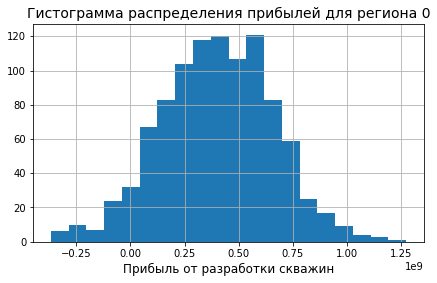

In [41]:
# Строим распределение прибыли с помощью bootstrap
profits_0 = []
for i in range(1000):

    df_subsample_0 = pred_geo_0.sample(n=BOREHOLES_RESEARCH, replace=True, random_state=state)
    profit_subsample_0 = profit_count(df_subsample_0, BOREHOLES)
    profits_0.append(profit_subsample_0)

# Преобразуем в Series
profits_0 = pd.Series(profits_0)

# Строим график распределения прибылей
plt.figure(figsize=(7, 4))
profits_0.hist(bins=20);
plt.title('Гистограмма распределения прибылей для региона 0', fontsize=14)
plt.xlabel('Прибыль от разработки скважин', fontsize=12)
plt.show()

На графике видно, что вероятность получения убытков от разработки скважин достаточно высокая. Рассчитаем эту вероятность.

In [42]:
print('\033[1m' + 'Показатели распределения прибыли для региона 0' +'\033[0m')

# Считаем среднее значение прибыли
print('-'*70)
mean_profit_0 = profits_0.mean()
print(f"Среднее значение прибыли: \033[1m{mean_profit_0:_.0f} ₽ \033[0m")

# Считаем 95%-й доверительный интервал
lower_0 = profits_0.quantile(0.025) / 1_000_000
upper_0 = profits_0.quantile(0.975) / 1_000_000
print(f"95%-й доверительный интервал прибыли: \033[1m от {lower_0:_.2f} млн.₽ до {upper_0:_.0f} млн.₽ \033[0m")

# Считаем минимальное значение прибыли
min_profit_0 = profits_0.min() / 1_000_000
print(f"Минимальное значение прибыли: \033[1m{min_profit_0:_.2f} млн.₽ \033[0m")

# Считаем вероятность получения убытков
percentile_0 = st.percentileofscore(profits_0, 0, kind='weak') # 'weak' - % значений <= 0
print(f"Вероятность получения убытков составляет: \033[1m{percentile_0:.2f}% \033[0m")
print('-'*70)

Показатели распределения прибыли для региона 0
----------------------------------------------------------------------
Среднее значение прибыли: 400_669_837 ₽ 
95%-й доверительный интервал прибыли:  от -115.72 млн.₽ до 902 млн.₽ 
Минимальное значение прибыли: -366.13 млн.₽ 
Вероятность получения убытков составляет: 5.80% 
----------------------------------------------------------------------


Если мы будем разрабатывать скважины в регионе "0", то с вероятностью 5.8% мы можем получить убытки. Это значительно выше, чем в задании (2.5%), поэтому этот регион не подходит для разработки. С вероятностью 95% значение прибыли от разработки скважин будет в диапазоне от -115.7 до 902 млн.₽. Но максимальный размер убытков может составить около 366 млн. ₽.

**Построим распределение прибыли с помощью bootstrap для региона 1**

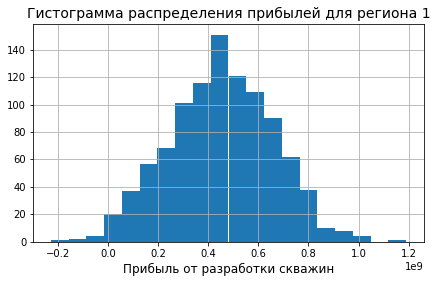

In [43]:
# Строим распределение прибыли с помощью bootstrap
profits_1 = []
for i in range(1000):

    df_subsample_1 = pred_geo_1.sample(n=BOREHOLES_RESEARCH, replace=True, random_state=state)
    profit_subsample_1 = profit_count(df_subsample_1, BOREHOLES)
    profits_1.append(profit_subsample_1)

# Преобразуем в Series
profits_1 = pd.Series(profits_1)

# Строим график распределения прибылей
plt.figure(figsize=(7, 4))
profits_1.hist(bins=20);
plt.title('Гистограмма распределения прибылей для региона 1', fontsize=14)
plt.xlabel('Прибыль от разработки скважин', fontsize=12)
plt.show()

На графике видно, что вероятность получения убытков от разработки скважин уже значительно ниже. Рассчитаем эту вероятность.

In [44]:
print('\033[1m' + 'Показатели распределения прибыли для региона 1' +'\033[0m')

# Считаем среднее значение прибыли
print('-'*70)
mean_profit_1 = profits_1.mean()
print(f"Среднее значение прибыли: \033[1m{mean_profit_1:_.0f} ₽ \033[0m")

# Считаем 95%-й доверительный интервал
lower_1 = profits_1.quantile(0.025) / 1_000_000
upper_1 = profits_1.quantile(0.975) / 1_000_000
print(f"95%-й доверительный интервал прибыли: \033[1m от {lower_1:_.2f} млн.₽ до {upper_1:_.0f} млн.₽ \033[0m")

# Считаем минимальное значение прибыли
min_profit_1 = profits_1.min() / 1_000_000
print(f"Минимальное значение прибыли: \033[1m{min_profit_1:_.2f} млн.₽ \033[0m")

# Считаем вероятность получения убытков
percentile_1 = st.percentileofscore(profits_1, 0, kind='weak') # 'weak' - % значений <= 0
print(f"Вероятность получения убытков составляет: \033[1m{percentile_1:.2f}% \033[0m")
print('-'*70)

Показатели распределения прибыли для региона 1
----------------------------------------------------------------------
Среднее значение прибыли: 452_562_288 ₽ 
95%-й доверительный интервал прибыли:  от 50.91 млн.₽ до 830 млн.₽ 
Минимальное значение прибыли: -226.54 млн.₽ 
Вероятность получения убытков составляет: 0.90% 
----------------------------------------------------------------------


Если мы будем разрабатывать скважины в регионе "1", то всего лишь с вероятностью 0.9% мы можем получить убытки. Это значительно ниже, чем в задании (2.5%), поэтому этот регион подходит для разработки. С вероятностью 95% значение прибыли от разработки скважин в регионе "1" будет в диапазоне от 50.9 до 830 млн.₽. Средняя вероятная прибыль больше на 52 млн.₽, чем в регионе "0". При этом максимальный размер убытков может составить около 226.5 млн. ₽.

**Построим распределение прибыли с помощью bootstrap для региона 2**

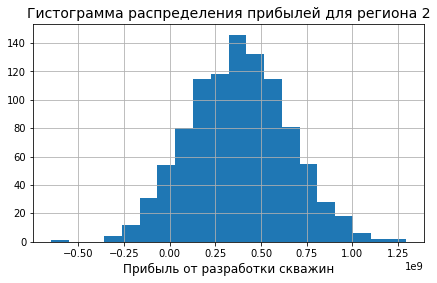

In [45]:
# Строим распределение прибыли с помощью bootstrap
profits_2 = []
for i in range(1000):

    df_subsample_2 = pred_geo_2.sample(n=BOREHOLES_RESEARCH, replace=True, random_state=state)
    profit_subsample_2 = profit_count(df_subsample_2, BOREHOLES)
    profits_2.append(profit_subsample_2)

# Преобразуем в Series
profits_2 = pd.Series(profits_2)

# Строим график распределения прибылей
plt.figure(figsize=(7, 4))
profits_2.hist(bins=20);
plt.title('Гистограмма распределения прибылей для региона 2', fontsize=14)
plt.xlabel('Прибыль от разработки скважин', fontsize=12)
plt.show()

На графике видно, что вероятность получения убытков от разработки скважин достаточно высокая. Рассчитаем эту вероятность.

In [46]:
print('\033[1m' + 'Показатели распределения прибыли для региона 2' +'\033[0m')

# Считаем среднее значение прибыли
print('-'*70)
mean_profit_2 = profits_2.mean()
print(f"Среднее значение прибыли: \033[1m{mean_profit_2:_.0f} ₽ \033[0m")

# Считаем 95%-й доверительный интервал
lower_2 = profits_2.quantile(0.025) / 1_000_000
upper_2 = profits_2.quantile(0.975) / 1_000_000
print(f"95%-й доверительный интервал прибыли: \033[1m от {lower_2:_.2f} млн.₽ до {upper_2:_.0f} млн.₽ \033[0m")

# Считаем минимальное значение прибыли
min_profit_2 = profits_2.min() / 1_000_000
print(f"Минимальное значение прибыли: \033[1m{min_profit_2:_.2f} млн.₽ \033[0m")

# Считаем вероятность получения убытков
percentile_2 = st.percentileofscore(profits_2, 0, kind='weak') # 'weak' - % значений <= 0
print(f"Вероятность получения убытков составляет: \033[1m{percentile_2:.2f}% \033[0m")
print('-'*70)

Показатели распределения прибыли для региона 2
----------------------------------------------------------------------
Среднее значение прибыли: 378_255_210 ₽ 
95%-й доверительный интервал прибыли:  от -136.14 млн.₽ до 914 млн.₽ 
Минимальное значение прибыли: -650.07 млн.₽ 
Вероятность получения убытков составляет: 7.80% 
----------------------------------------------------------------------


Если мы будем разрабатывать скважины в регионе "2", то с вероятностью 7.8% мы можем получить убытки. Это значительно выше, чем в задании (2.5%), поэтому этот регион не подходит для разработки. Это самая высокая вероятность получения убытков из всех регионов. С вероятностью 95% значение прибыли от разработки скважин будет в диапазоне от -136.1 до 914 млн.₽. При этом максимальный размер убытков может составить около 650 млн. ₽.

**Общий вывод:**<br>

* <font color='darkgreen'> Из всех трех предложенных регионов для разработки скважин подходит только регион **"1"**. С вероятностью 95% значение прибыли от разработки скважин в регионе "1" будет в диапазоне **от 50.9 до 830 млн.₽.** Вероятность получить убытки от разработки скважин в этом регионе составляет всего **0.9%**. Но даже при такой незначительной вероятности максимальный размер убытка может составить около **226 млн. ₽.** Среднее значение ожинаемой прибыли составляет **452.5 млн.₽.** При этом этот регион имеет самое низкое среднее фактическое значение запасов сырья на одну скважину.</font><br>


* <font color='darkred'> Регион **"0"** не подходит для разработки, так как вероятность получить убытки от разработки скважин в этом регионе составляет около **5.8%**. Это значительно выше, чем в задании (2.5%). С вероятностью 95% значение прибыли от разработки скважин будет в диапазоне **от -115.7 до 902 млн.₽.** А максимальный размер убытков может составить около **366 млн. ₽.**</font><br>


* <font color='darkred'> Регион **"2"** тоже не подходит для разработки, так как вероятность получить убытки от разработки скважин в этом регионе составляет около **7.8%**. Это тоже значительно выше, чем в задании (2.5%). С вероятностью 95% значение прибыли от разработки скважин в этом регионе будет в диапазоне **от -136.1 до 914 млн.₽.** При этом максимальный размер убытков может составить около **650 млн. ₽**. Это самое большое значение вероятного убытка.</font><br>